In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Oil and Gas Exploration and Production in the State of Kentucky Shown as Quarter-Mile Cells
Citation: Biewick, L.R., 2008, Oil and Gas Exploration and Production in the State of Kentucky Shown as Quarter-Mile Cells: U.S. Geological Survey data release,   
**https://doi.org/10.5066/P13NZURP.**  
Summary: A cells polygon feature class was created by the U.S. Geological Survey (USGS) to illustrate the degree of exploration, type of production, and distribution of production in the State of Kentucky. Each cell represents a quarter-mile square of the land surface, and the cells are coded to represent whether the wells included within the cell are predominantly oil-producing, gas-producing, both oil and gas-producing, or the type of production of the wells located within the cell is unknown or dry. Data were retrieved from the Kentucky Oil and Gas Well Records database and saved as a shapefile of oil and gas well locations for Kentucky. Cells were developed as a graphic solution to overcome the problem of displaying proprietary well data. No proprietary data are displayed or included in the cell maps. The data are current as of 2005.

In [2]:
shapefile_path = "kycells05g/kycells05g.shp"
gdf = gpd.read_file(shapefile_path)
print(gdf.head())

   CC83XCOORD  CC83YCOORD  CELLSYMB  \
0  -87.612162   37.456436         4   
1  -82.175694   37.456213         2   
2  -84.759818   37.456264         1   
3  -87.105100   37.456329         4   
4  -87.713574   37.456204         4   

                                            geometry  
0  POLYGON ((-87.61633 37.46033, -87.60718 37.459...  
1  POLYGON ((-82.17957 37.46028, -82.17049 37.459...  
2  POLYGON ((-84.76492 37.45312, -84.76384 37.460...  
3  POLYGON ((-87.10924 37.46024, -87.1001 37.4595...  
4  POLYGON ((-87.71775 37.46009, -87.7086 37.4594...  


In [3]:
print("\n--- Shapefile Metadata ---")
print(gdf.info())
print("\n--- Coordinate Reference System (CRS) ---")
print(gdf.crs)
print("\n--- Column Names ---")
print(gdf.columns)
print("\n--- Geometry Type ---")
print(gdf.geom_type.value_counts())
print(f"\nTotal Number of Features: {len(gdf)}")


--- Shapefile Metadata ---
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32478 entries, 0 to 32477
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CC83XCOORD  32478 non-null  float64 
 1   CC83YCOORD  32478 non-null  float64 
 2   CELLSYMB    32478 non-null  int64   
 3   geometry    32478 non-null  geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 1015.1 KB
None

--- Coordinate Reference System (CRS) ---
GEOGCS["DD_NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]

--- Column Names ---
Index(['CC83XCOORD', 'CC83YCOORD', 'CELLSYMB', 'geometry'], dtype='object')

--- Geometry Type ---
Polygon    32478
Name: count, dtype: int64

Total Number of Features: 32478


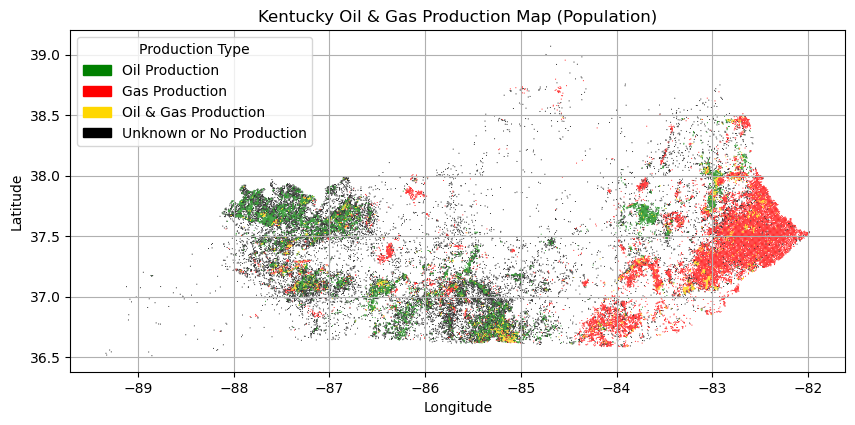

In [4]:
# Define production types and corresponding colors
production_labels = {
    1: "Oil Production",
    2: "Gas Production",
    3: "Oil & Gas Production",
    4: "Unknown or No Production"
}

production_colors = {
    1: "green",
    2: "red",
    3: "gold",
    4: "black"
}

# Plot the oil and gas production map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each category separately
for prod_type, color in production_colors.items():
    subset = gdf[gdf["CELLSYMB"] == prod_type]
    subset.plot(ax=ax, color=color, label=production_labels[prod_type])

# Manually create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in zip(production_labels.values(), production_colors.values())]
ax.legend(handles=legend_patches, loc="upper left", title="Production Type")

# Add titles and labels
ax.set_title("Kentucky Oil & Gas Production Map (Population)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plt.show()

In [5]:
import numpy as np
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from shapely.geometry import Point

In [6]:

# Extract coordinates and production labels
X = gdf["CC83XCOORD"].values
Y = gdf["CC83YCOORD"].values
labels = gdf["CELLSYMB"].values  # 1: Oil, 2: Gas, 3: Both, 4: Unknown

In [7]:

# Convert categorical labels into indicators
oil_indicator = (gdf['CELLSYMB'] == 1).astype(int)  # 1 if oil, else 0
gas_indicator = (gdf['CELLSYMB'] == 2).astype(int)  # 1 if gas, else 0
both_indicator = (gdf['CELLSYMB'] == 3).astype(int)  # 1 if both, else 0

In [8]:
# Define the kriging grid (extent of the dataset)
grid_x = np.linspace(X.min(), X.max(), 80)  # Adjust resolution if needed
grid_y = np.linspace(Y.min(), Y.max(), 50)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

In [9]:
# Randomly sample 100 points for each category
np.random.seed(42)  # For reproducibility
sample_size = 1000

In [10]:
def sample_points(X, Y, indicator):
    """Randomly sample points from the dataset while maintaining spatial variability."""
    indices = np.where(indicator == 1)[0]  # Get indices of relevant category
    if len(indices) > sample_size:
        sampled_indices = np.random.choice(indices, sample_size, replace=False)
    else:
        sampled_indices = indices  # Use all available points if less than sample_size
    return X[sampled_indices], Y[sampled_indices], indicator[sampled_indices]

In [11]:
# Sampled points for each category
X_oil, Y_oil, oil_sample = sample_points(X, Y, oil_indicator)
X_gas, Y_gas, gas_sample = sample_points(X, Y, gas_indicator)
X_both, Y_both, both_sample = sample_points(X, Y, both_indicator)

In [12]:
gdf.shape

(32478, 4)

In [13]:
oil_sample.shape

(1000,)

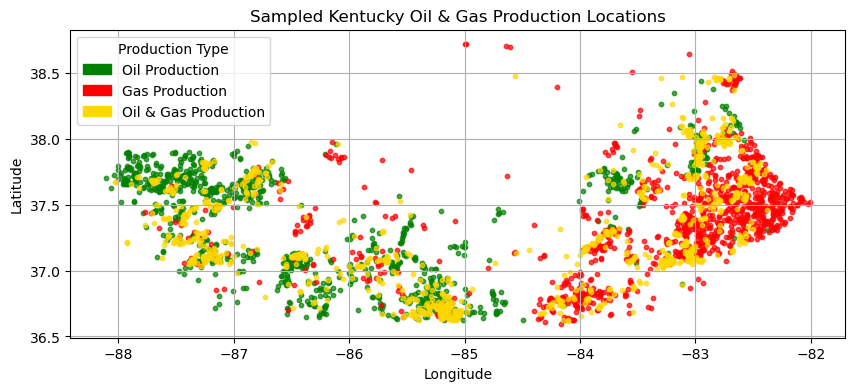

In [14]:

# Create a new figure for sampled points
fig, ax = plt.subplots(figsize=(10, 4))

# Plot sampled oil production points
ax.scatter(X_oil, Y_oil, color="green", label="Oil Production (Sampled)", s=10, alpha=0.7)

# Plot sampled gas production points
ax.scatter(X_gas, Y_gas, color="red", label="Gas Production (Sampled)", s=10, alpha=0.7)

# Plot sampled oil & gas production points
ax.scatter(X_both, Y_both, color="gold", label="Oil & Gas Production (Sampled)", s=10, alpha=0.7)

# Manually create legend patches
legend_patches = [
    mpatches.Patch(color="green", label="Oil Production"),
    mpatches.Patch(color="red", label="Gas Production"),
    mpatches.Patch(color="gold", label="Oil & Gas Production")
]

# Add legend
ax.legend(handles=legend_patches, loc="upper left", title="Production Type")

# Titles and labels
ax.set_title("Sampled Kentucky Oil & Gas Production Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)

# Show the plot
plt.show()

In [15]:
# Ensure valid points (remove NaN and duplicates)
def clean_data(x, y, values):
    """Remove NaN and duplicate points to avoid Kriging errors."""
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(values)
    x, y, values = x[mask], y[mask], values[mask]
    
    unique_points = np.unique(np.column_stack((x, y)), axis=0)
    if len(unique_points) < 5:  # PyKrige needs at least 5 unique points
        print("Not enough unique points for kriging, skipping...")
        return None, None, None
    return x, y, values

In [16]:
X_oil, Y_oil, oil_sample = clean_data(X_oil, Y_oil, oil_sample)
X_gas, Y_gas, gas_sample = clean_data(X_gas, Y_gas, gas_sample)
X_both, Y_both, both_sample = clean_data(X_both, Y_both, both_sample)

In [17]:
# Function to perform ordinary kriging and return both estimate & variance
def perform_kriging(x, y, values, grid_x, grid_y, var_model="linear", var_nugg=0.1, var_range=4, var_sill=0.99, var_slope=0.3):
    """Perform Indicator Kriging on sampled data and return interpolated probabilities & variance."""
    if x is None or len(x) < 5:  # Skip if not enough data
        return np.full((len(grid_y), len(grid_x)), np.nan), np.full((len(grid_y), len(grid_x)), np.nan)
    
    try:
        if var_model == "linear":
            OK = UniversalKriging(
                x, y, values,
                variogram_model="linear",
                variogram_parameters={"slope": 0.3, "nugget": var_nugg},  # Manual parameters
                verbose=False, enable_plotting=False, pseudo_inv=True
        )
        else:
            OK = UniversalKriging(
                x, y, values,
                variogram_model="gaussian", 
                variogram_parameters={"sill": var_sill, "range": var_range, "nugget": var_nugg},  # Manual parameters
                verbose=False, enable_plotting=False, pseudo_inv=True
        )
        z_pred, ss = OK.execute("grid", grid_x, grid_y)
        return z_pred, ss
    except ValueError as e:
        print(f"Kriging failed: {e}")
        return np.full((len(grid_y), len(grid_x)), np.nan), np.full((len(grid_y), len(grid_x)), np.nan)

In [18]:
# Function to plot probability, uncertainty, and an overlayed combination
def plot_probability_uncertainty(grid_x, grid_y, prob, var, title_prob, title_var, cmap_prob, cmap_var):
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))  # Stack plots vertically

    # Probability Map (Top)
    ax = axes[0]
    c_prob = ax.contourf(grid_x, grid_y, prob, cmap=cmap_prob, levels=20)
    plt.colorbar(c_prob, ax=ax, label="Kriging prediction")
    ax.set_title(title_prob)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Uncertainty Map (Middle)
    ax = axes[1]
    c_var = ax.contourf(grid_x, grid_y, var, cmap=cmap_var, levels=20)
    plt.colorbar(c_var, ax=ax, label="Uncertainty (Variance)")
    ax.set_title(title_var)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Combined Overlay (Bottom)
    ax = axes[2]
    norm_var = (var - np.min(var)) / (np.max(var) - np.min(var) + 1e-8)  # Normalize variance to [0,1]
    alpha_vals = 1 - norm_var  # More variance → More transparent

    # Ensure alpha is properly applied, fix upside-down issue with `origin='lower'`
    prob_overlay = ax.imshow(prob, cmap=cmap_prob, extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], 
                            alpha=alpha_vals, origin='lower')

    plt.colorbar(prob_overlay, ax=ax, label="Probability (Transparency = Certainty)")
    ax.set_title("Prediction with Transparency Based on Uncertainty")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()

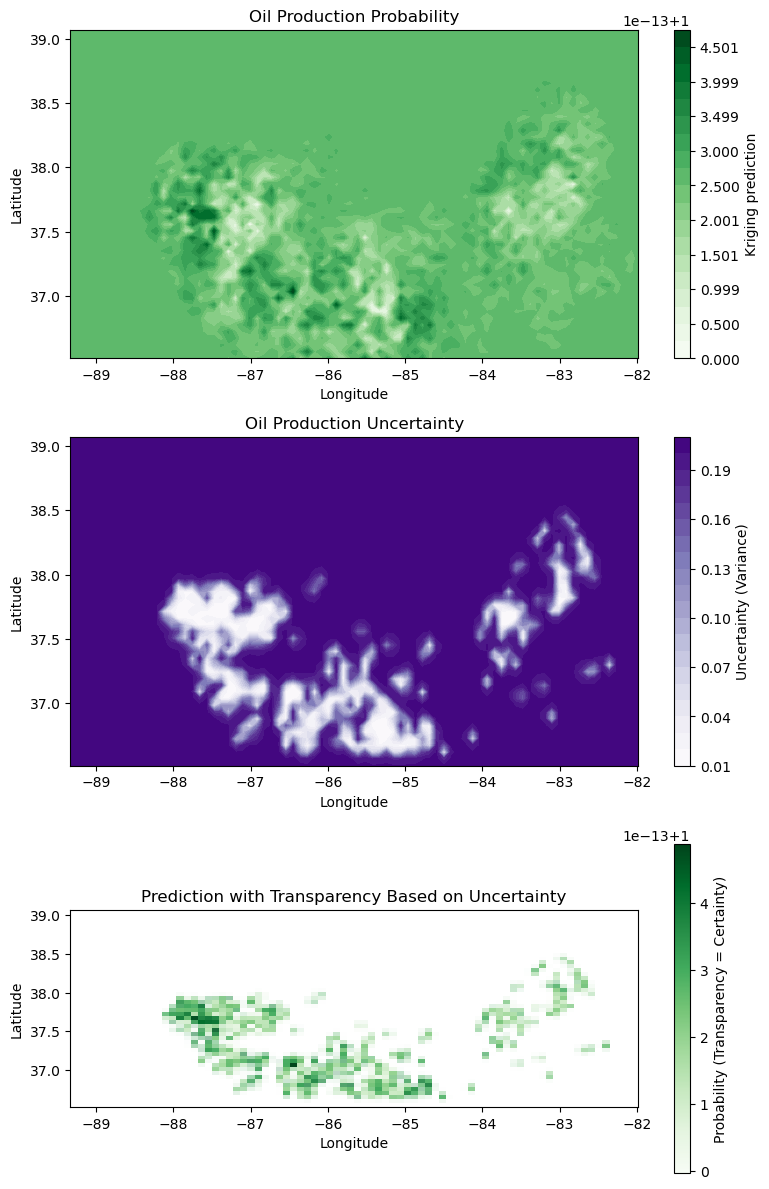

In [19]:
# Run kriging interpolation for oil production
oil_prob, oil_var = perform_kriging(X_oil, Y_oil, oil_sample, 
                                    grid_x, grid_y, 
                                    var_model="gaussian", var_nugg=0.01, 
                                    var_range=0.1, var_sill=0.2)

plot_probability_uncertainty(grid_x, grid_y, oil_prob, oil_var, 
                             "Oil Production Probability", "Oil Production Uncertainty", 
                             cmap_prob="Greens", cmap_var="Purples")

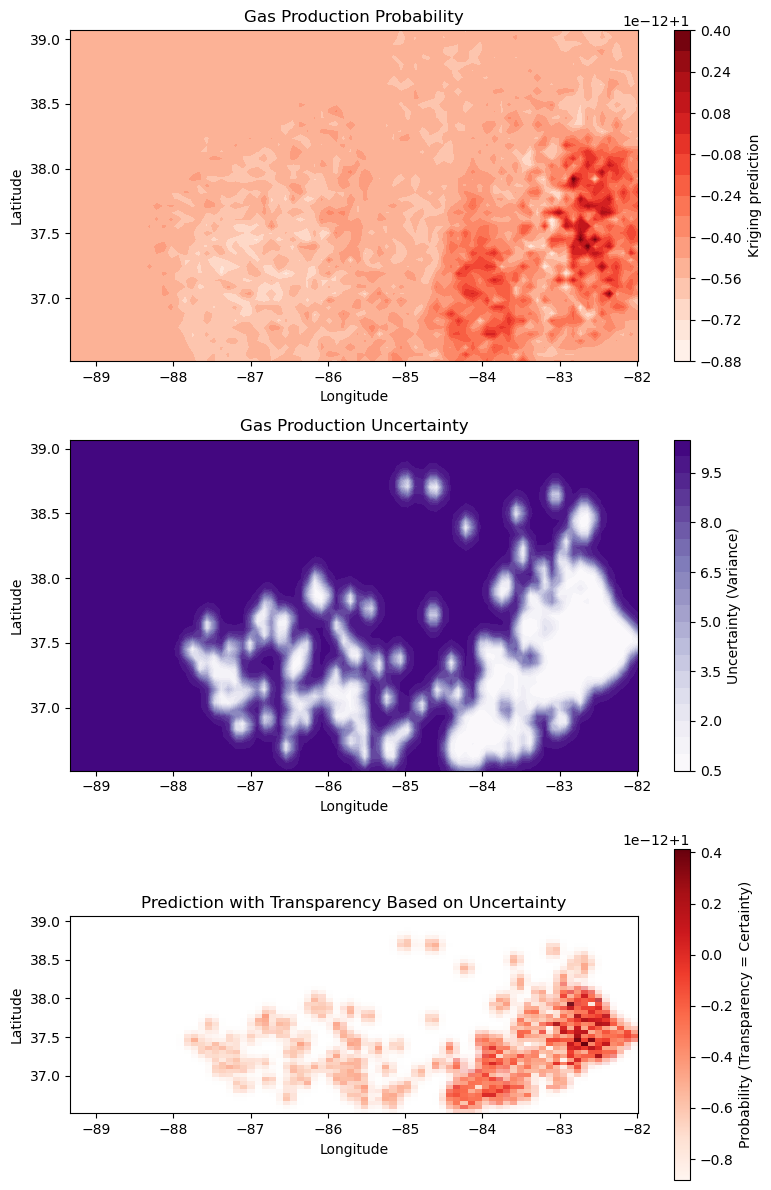

gas probability max/min [np.float64(0.9999999999991183), np.float64(1.0000000000004128)]


In [20]:
gas_prob, gas_var = perform_kriging(X_gas, Y_gas, gas_sample, grid_x, grid_y, var_model="gaussian", var_nugg=0.5, var_range=0.2, var_sill=10)

plot_probability_uncertainty(grid_x, grid_y, gas_prob, gas_var, 
                             "Gas Production Probability", "Gas Production Uncertainty", 
                             cmap_prob="Reds", cmap_var="Purples")
print("gas probability max/min", [gas_prob.min(), gas_prob.max()])

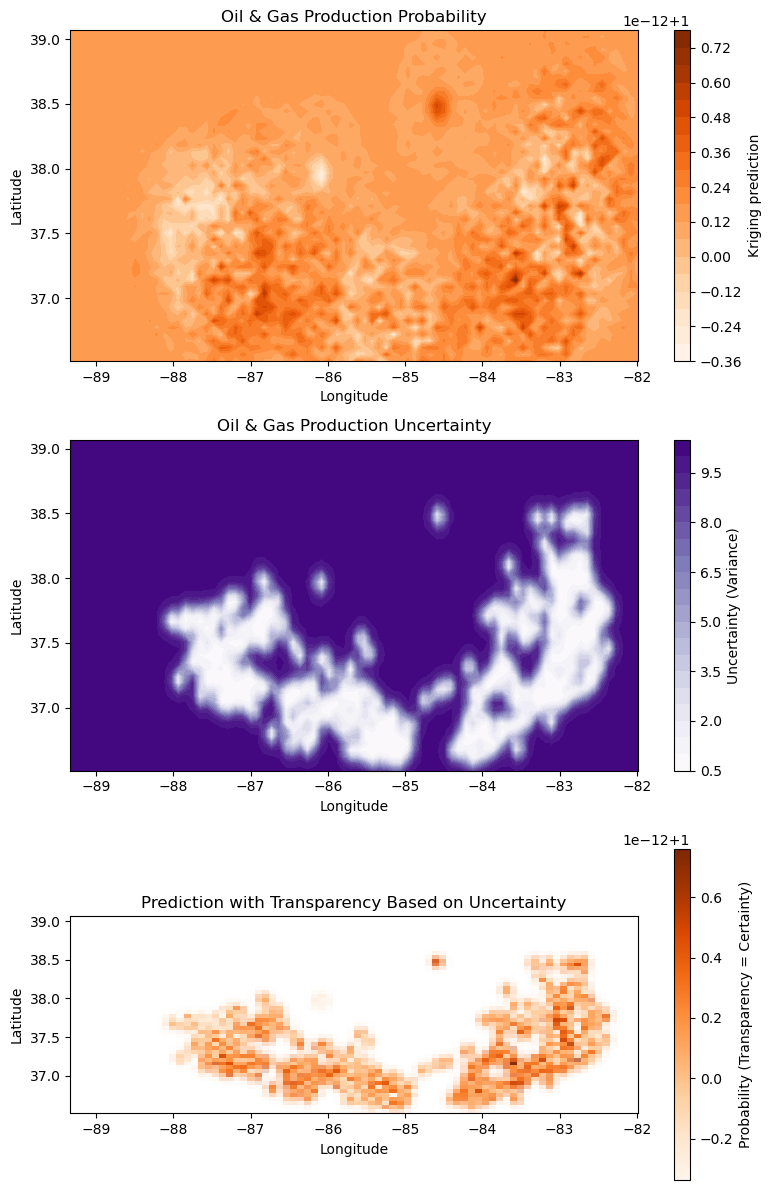

In [21]:
both_prob, both_var = perform_kriging(X_both, Y_both, both_sample, grid_x, grid_y, var_model="gaussian", var_nugg=0.5, var_range=0.2, var_sill=10)
plot_probability_uncertainty(grid_x, grid_y, both_prob, both_var, 
                             "Oil & Gas Production Probability", "Oil & Gas Production Uncertainty", 
                             cmap_prob="Oranges", cmap_var="Purples")

In [22]:
shapefile_path_ky_counties = "tl_2016_21_cousub/tl_2016_21_cousub.shp"
gdf_ky_counties = gpd.read_file(shapefile_path_ky_counties)

In [23]:
gdf_ky_counties.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,21,197,93352,01937275,2119793352,Stanton,Stanton CCD,22,Z5,G4040,None,None,None,S,291796978,1317168,+37.8045838,-083.7593325,"POLYGON ((-83.89152 37.86032, -83.89113 37.860..."
1,21,211,91616,01937047,2121191616,Harrisonville,Harrisonville CCD,22,Z5,G4040,None,None,None,S,254643910,2894815,+38.1331753,-085.1011773,"POLYGON ((-85.23253 38.08962, -85.23245 38.089..."
2,21,211,90696,01936932,2121190696,Christianburg,Christianburg CCD,22,Z5,G4040,None,None,None,S,170496590,1999098,+38.2800904,-085.0630983,"POLYGON ((-85.15292 38.3479, -85.15261 38.3478..."
3,21,211,93232,01937260,2121193232,Simpsonville,Simpsonville CCD,22,Z5,G4040,None,None,None,S,206267917,4037979,+38.2159128,-085.3531810,"POLYGON ((-85.46821 38.28531, -85.46754 38.285..."
4,21,035,91936,01937091,2103591936,Kirksey,Kirksey CCD,22,Z5,G4040,None,None,None,S,199954074,1293833,+36.7028365,-088.3851708,"POLYGON ((-88.48703 36.65894, -88.48703 36.659..."


<Axes: >

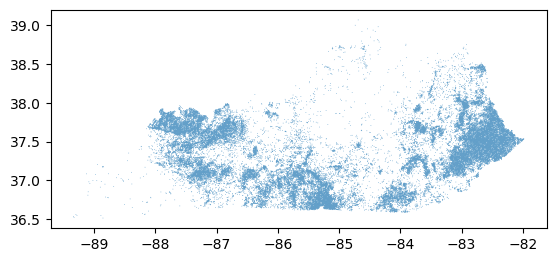

In [24]:
gdf.plot()

<Axes: >

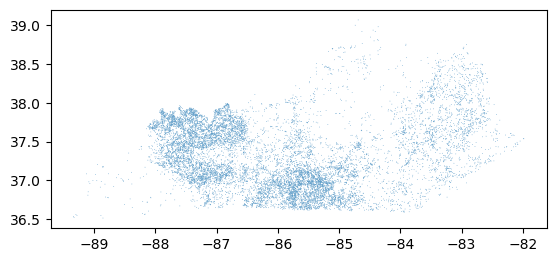

In [25]:
subset.plot()

In [26]:
# Ensure both GeoDataFrames have the same CRS
gdf = gdf.to_crs(gdf_ky_counties.crs)

# Separate oil and gas wells
gdf_oil = gdf[gdf['CELLSYMB'].isin([1, 3])]  # 1 = Oil, 3 = Both
gdf_gas = gdf[gdf['CELLSYMB'].isin([2, 3])]  # 2 = Gas, 3 = Both

# Spatial join to assign wells to counties
oil_per_county = gpd.sjoin(gdf_oil, gdf_ky_counties, how="inner", predicate="within")
gas_per_county = gpd.sjoin(gdf_gas, gdf_ky_counties, how="inner", predicate="within")

# Count wells per county
oil_counts = oil_per_county.groupby("NAME").size().reset_index(name="oil_wells")
gas_counts = gas_per_county.groupby("NAME").size().reset_index(name="gas_wells")

# Merge counts into counties GeoDataFrame
gdf_ky_counties = gdf_ky_counties.merge(oil_counts, on="NAME", how="left").fillna(0)
gdf_ky_counties = gdf_ky_counties.merge(gas_counts, on="NAME", how="left").fillna(0)

# Compute well density (wells per square km)
gdf_ky_counties["oil_density"] = gdf_ky_counties["oil_wells"] / gdf_ky_counties["geometry"].area
gdf_ky_counties["gas_density"] = gdf_ky_counties["gas_wells"] / gdf_ky_counties["geometry"].area

# Convert to wells per 1000 sq km for better readability
gdf_ky_counties["oil_density"] *= 1e6
gdf_ky_counties["gas_density"] *= 1e6

/var/folders/08/fcnqv5n16bd3p26sxm806b080000gp/T/ipykernel_92947/400263793.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf_ky_counties = gdf_ky_counties.merge(oil_counts, on="NAME", how="left").fillna(0)
/var/folders/08/fcnqv5n16bd3p26sxm806b080000gp/T/ipykernel_92947/400263793.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_ky_counties["oil_density"] = gdf_ky_counties["oil_wells"] / gdf_ky_counties["geometry"].area
/var/folders/08/fcnqv5n16bd3p26sxm806b080000gp/T/ipykernel_92947/400263793.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-proj

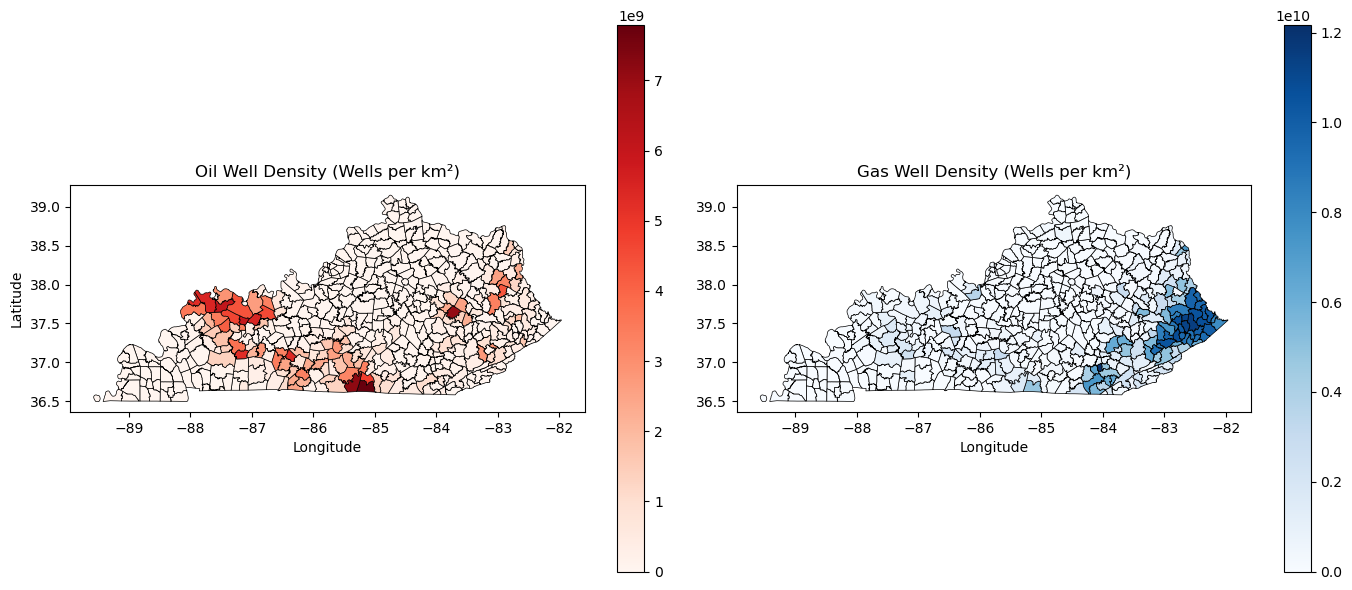

In [27]:
import matplotlib.pyplot as plt

# Create figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Oil Well Density
gdf_ky_counties.plot(column="oil_density", cmap="Reds", linewidth=0.5, edgecolor="black", legend=True, ax=axes[0])
axes[0].set_title("Oil Well Density (Wells per km²)")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Plot Gas Well Density
gdf_ky_counties.plot(column="gas_density", cmap="Blues", linewidth=0.5, edgecolor="black", legend=True, ax=axes[1])
axes[1].set_title("Gas Well Density (Wells per km²)")
axes[1].set_xlabel("Longitude")

# Adjust layout
plt.tight_layout()
plt.show()

In [28]:
# Load the health data CSV
ky_health = pd.read_csv("ky_health.csv")

# Standardize county names by stripping whitespace and converting to lowercase
ky_health["County"] = ky_health["County"].str.strip().str.lower()
gdf_ky_counties["NAME"] = gdf_ky_counties["NAME"].str.strip().str.lower()

# Handle any mismatched names (this step is optional but useful for debugging)
missing_counties = set(ky_health["County"]) - set(gdf_ky_counties["NAME"])
print("Counties in ky_health but not in gdf_ky_counties:", missing_counties)

# Manually correct known mismatches (if necessary)
name_corrections = {
    "mc cracken": "mccracken",  # Example fix for spacing issues
    "christianburg": "christian",  # Example: if county names don't match exactly
}

ky_health["County"] = ky_health["County"].replace(name_corrections)

# Merge using the cleaned names
gdf_ky_counties = gdf_ky_counties.merge(ky_health, left_on="NAME", right_on="County", how="left")

# Verify the merge worked
print(gdf_ky_counties[["NAME", "life_exp", "95low", "95high"]].dropna().head())

Counties in ky_health but not in gdf_ky_counties: {'taylor', 'mccreary', 'magoffin', 'mclean', 'fayette', 'fleming', 'whitley', 'meade', 'woodford', 'madison', 'harrison', 'owen', 'warren', 'monroe', 'marshall', 'christian', 'martin', 'wolfe', 'letcher', 'lincoln', 'russell', 'wayne', 'garrard', 'todd', 'morgan', 'anderson', 'allen', 'hancock', 'washington', 'bath', 'clark', 'gallatin', 'muhlenberg', 'carroll', 'caldwell', 'knox', 'floyd', 'campbell', 'simpson', 'mercer', 'powell', 'mason', 'robertson', 'montgomery', 'leslie', 'hardin', 'henry', 'lee', 'casey', 'bourbon', 'lawrence', 'trigg', 'bracken', 'bullitt', 'menifee', 'owsley', 'jefferson', nan, 'pulaski', 'johnson', 'adair', 'webster', 'perry', 'breckinridge', 'green', 'pendleton', 'rockcastle', 'nicholas', 'grant', 'breathitt', 'boyle', 'estill', 'hopkins', 'edmonson', 'jessamine', 'mccracken', 'nelson', 'rowan', 'bell', 'hart', 'shelby', 'lewis', 'larue', 'metcalfe', 'spencer', 'trimble', 'ohio', 'scott', 'graves', 'boyd', 'd

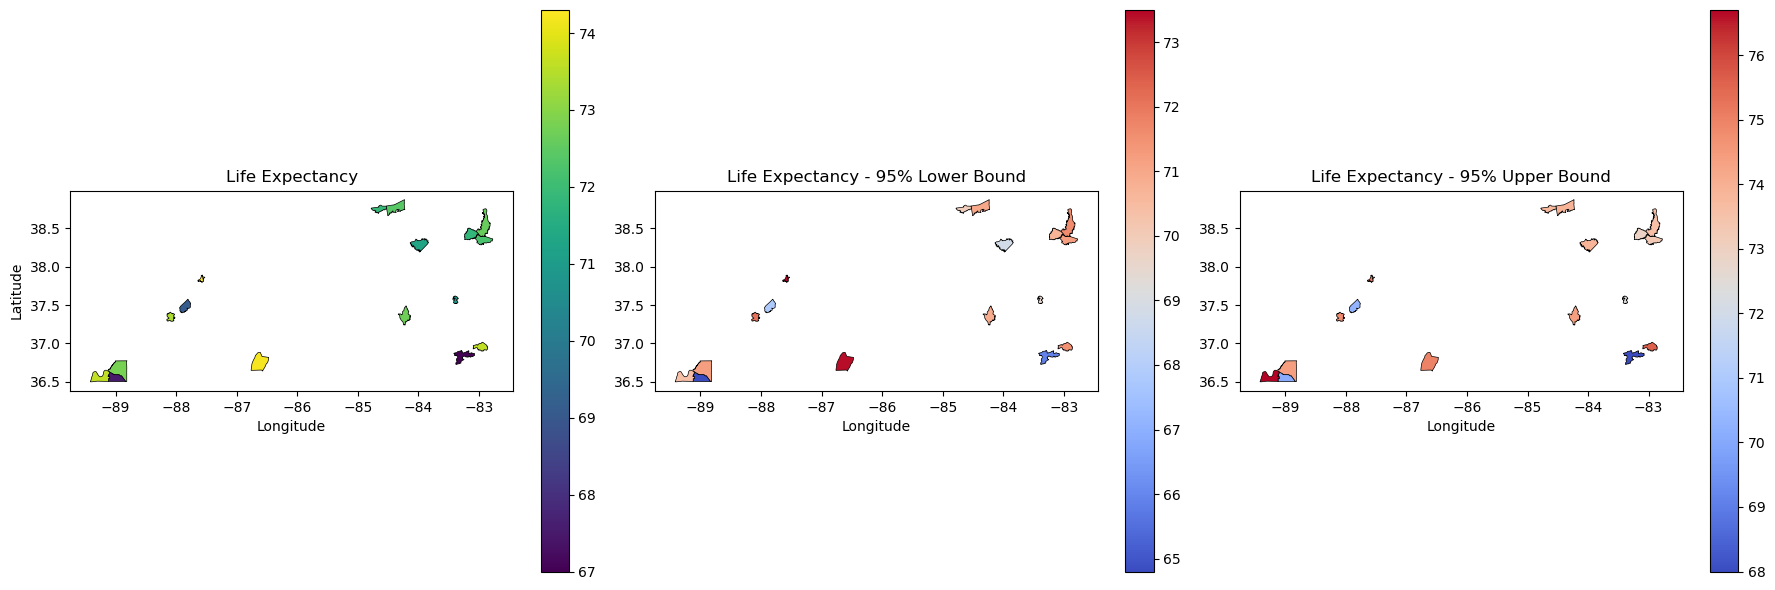

In [29]:
# Create figure and axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Life Expectancy
gdf_ky_counties.plot(column="life_exp", cmap="viridis", linewidth=0.5, edgecolor="black", legend=True, ax=axes[0])
axes[0].set_title("Life Expectancy")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# 95% Confidence Interval (Lower Bound)
gdf_ky_counties.plot(column="95low", cmap="coolwarm", linewidth=0.5, edgecolor="black", legend=True, ax=axes[1])
axes[1].set_title("Life Expectancy - 95% Lower Bound")
axes[1].set_xlabel("Longitude")

# 95% Confidence Interval (Upper Bound)
gdf_ky_counties.plot(column="95high", cmap="coolwarm", linewidth=0.5, edgecolor="black", legend=True, ax=axes[2])
axes[2].set_title("Life Expectancy - 95% Upper Bound")
axes[2].set_xlabel("Longitude")

# Adjust layout
plt.tight_layout()
plt.show()

In [30]:
gdf_ky_counties

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,geometry,oil_wells,gas_wells,oil_density,gas_density,State,County,life_exp,95low,95high
0,21,197,93352,01937275,2119793352,stanton,Stanton CCD,22,Z5,G4040,...,"POLYGON ((-83.89152 37.86032, -83.89113 37.860...",37.0,24.0,1.233552e+09,8.001419e+08,NaN,NaN,NaN,NaN,NaN
1,21,211,91616,01937047,2121191616,harrisonville,Harrisonville CCD,22,Z5,G4040,...,"POLYGON ((-85.23253 38.08962, -85.23245 38.089...",0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
2,21,211,90696,01936932,2121190696,christianburg,Christianburg CCD,22,Z5,G4040,...,"POLYGON ((-85.15292 38.3479, -85.15261 38.3478...",0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
3,21,211,93232,01937260,2121193232,simpsonville,Simpsonville CCD,22,Z5,G4040,...,"POLYGON ((-85.46821 38.28531, -85.46754 38.285...",0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
4,21,035,91936,01937091,2103591936,kirksey,Kirksey CCD,22,Z5,G4040,...,"POLYGON ((-88.48703 36.65894, -88.48703 36.659...",0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,21,015,90440,01936900,2101590440,burlington,Burlington CCD,22,Z5,G4040,...,"POLYGON ((-84.89729 39.05744, -84.89728 39.057...",0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
489,21,181,91664,01937053,2118191664,headquarters,Headquarters CCD,22,Z5,G4040,...,"POLYGON ((-84.19251 38.37319, -84.19085 38.374...",0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
490,21,181,90592,01936919,2118190592,carlisle,Carlisle CCD,22,Z5,G4040,...,"POLYGON ((-84.137 38.31188, -84.13678 38.31199...",0.0,0.0,0.000000e+00,0.000000e+00,Kentucky,carlisle,71.3,68.8,73.9
491,21,049,93269,01936934,2104993269,southeast clark,Southeast Clark CCD,22,Z5,G4040,...,"POLYGON ((-84.22439 37.87714, -84.22408 37.877...",0.0,10.0,0.000000e+00,4.449166e+08,NaN,NaN,NaN,NaN,NaN


In [31]:
print(ky_health['County'].tolist())

[nan, 'adair', 'allen', 'anderson', 'ballard', 'barren', 'bath', 'bell', 'boone', 'bourbon', 'boyd', 'boyle', 'bracken', 'breathitt', 'breckinridge', 'bullitt', 'butler', 'caldwell', 'calloway', 'campbell', 'carlisle', 'carroll', 'carter', 'casey', 'christian', 'clark', 'clay', 'clinton', 'crittenden', 'cumberland', 'daviess', 'edmonson', 'elliott', 'estill', 'fayette', 'fleming', 'floyd', 'franklin', 'fulton', 'gallatin', 'garrard', 'grant', 'graves', 'grayson', 'green', 'greenup', 'hancock', 'hardin', 'harlan', 'harrison', 'hart', 'henderson', 'henry', 'hickman', 'hopkins', 'jackson', 'jefferson', 'jessamine', 'johnson', 'kenton', 'knott', 'knox', 'larue', 'laurel', 'lawrence', 'lee', 'leslie', 'letcher', 'lewis', 'lincoln', 'livingston', 'logan', 'lyon', 'mccracken', 'mccreary', 'mclean', 'madison', 'magoffin', 'marion', 'marshall', 'martin', 'mason', 'meade', 'menifee', 'mercer', 'metcalfe', 'monroe', 'montgomery', 'morgan', 'muhlenberg', 'nelson', 'nicholas', 'ohio', 'oldham', 'ow

In [32]:
print(gdf_ky_counties['NAME'].tolist())

['stanton', 'harrisonville', 'christianburg', 'simpsonville', 'kirksey', 'new concord', 'arlington', 'middleburg', 'grayson', 'upper tygart', 'pond creek', 'south dixie', 'north dixie', 'louisville airport', 'central jefferson', 'southeast jefferson', 'east jefferson', 'northeast jefferson', 'floyds fork', 'south jefferson', 'waco-bybee', 'boonesborough-white hall', 'rochester', 'morgantown', 'hawesville', 'lewisport', 'mount victory', 'shopville', 'eubank', 'science hill', 'fort knox', 'west menifee', 'blaine', 'clifford', 'fedscreek', 'mccarr', 'mayflower', 'raccoon', 'south williamson', 'cannonsburg', 'catlettsburg', 'jetson', 'sugar grove', 'welchs creek', 'st. johns-freemont', 'calhoun', 'daisy', 'bush', 'colony', 'london', 'mays lick', 'malaga', 'foster', 'maysville', 'emmalena', 'colson', 'eolia', 'sebree', 'central city', 'drakesboro', 'rosewood', 'rousseau', 'taulbee', 'dixon', 'beattyville', 'salem', 'inez', 'land between the lakes', 'adairville', 'lewisburg', 'west liberty',

In [33]:
# Import county FIPS code reference from Census
ky_county_fips = {
    '001': 'Adair', '003': 'Allen', '005': 'Anderson', '007': 'Ballard',
    '009': 'Barren', '011': 'Bath', '013': 'Bell', '015': 'Boone',
    '017': 'Bourbon', '019': 'Boyd', '021': 'Boyle', '023': 'Bracken',
    '025': 'Breathitt', '027': 'Breckinridge', '029': 'Bullitt', '031': 'Butler',
    '033': 'Caldwell', '035': 'Calloway', '037': 'Campbell', '039': 'Carlisle',
    '041': 'Carroll', '043': 'Carter', '045': 'Casey', '047': 'Christian',
    '049': 'Clark', '051': 'Clay', '053': 'Clinton', '055': 'Crittenden',
    '057': 'Cumberland', '059': 'Daviess', '061': 'Edmonson', '063': 'Elliott',
    '065': 'Estill', '067': 'Fayette', '069': 'Fleming', '071': 'Floyd',
    '073': 'Franklin', '075': 'Fulton', '077': 'Gallatin', '079': 'Garrard',
    '081': 'Grant', '083': 'Graves', '085': 'Grayson', '087': 'Green',
    '089': 'Greenup', '091': 'Hancock', '093': 'Hardin', '095': 'Harlan',
    '097': 'Harrison', '099': 'Hart', '101': 'Henderson', '103': 'Henry',
    '105': 'Hickman', '107': 'Hopkins', '109': 'Jackson', '111': 'Jefferson',
    '113': 'Jessamine', '115': 'Johnson', '117': 'Kenton', '119': 'Knott',
    '121': 'Knox', '123': 'Larue', '125': 'Laurel', '127': 'Lawrence',
    '129': 'Lee', '131': 'Leslie', '133': 'Letcher', '135': 'Lewis',
    '137': 'Lincoln', '139': 'Livingston', '141': 'Logan', '143': 'Lyon',
    '145': 'McCracken', '147': 'McCreary', '149': 'McLean', '151': 'Madison',
    '153': 'Magoffin', '155': 'Marion', '157': 'Marshall', '159': 'Martin',
    '161': 'Mason', '163': 'Meade', '165': 'Menifee', '167': 'Mercer',
    '169': 'Metcalfe', '171': 'Monroe', '173': 'Montgomery', '175': 'Morgan',
    '177': 'Muhlenberg', '179': 'Nelson', '181': 'Nicholas', '183': 'Ohio',
    '185': 'Oldham', '187': 'Owen', '189': 'Owsley', '191': 'Pendleton',
    '193': 'Perry', '195': 'Pike', '197': 'Powell', '199': 'Pulaski',
    '201': 'Robertson', '203': 'Rockcastle', '205': 'Rowan', '207': 'Russell',
    '209': 'Scott', '211': 'Shelby', '213': 'Simpson', '215': 'Spencer',
    '217': 'Taylor', '219': 'Todd', '221': 'Trigg', '223': 'Trimble',
    '225': 'Union', '227': 'Warren', '229': 'Washington', '231': 'Wayne',
    '233': 'Webster', '235': 'Whitley', '237': 'Wolfe', '239': 'Woodford'
}

# Standardize COUNTYFP codes in gdf_ky_counties
gdf_ky_counties["COUNTYFP"] = gdf_ky_counties["COUNTYFP"].astype(str).str.zfill(3)

# Map correct county names using FIPS codes
gdf_ky_counties["County"] = gdf_ky_counties["COUNTYFP"].map(ky_county_fips).str.lower()

In [36]:
# Standardize county names in ky_health
ky_health["County"] = ky_health["County"].str.lower()

# Merge using cleaned county names
gdf_ky_counties = gdf_ky_counties.merge(ky_health, on="County", how="left")

# Check for missing counties
print("Counties missing after merge:", gdf_ky_counties[gdf_ky_counties["life_exp"].isna()]["County"].unique())

Counties missing after merge: []


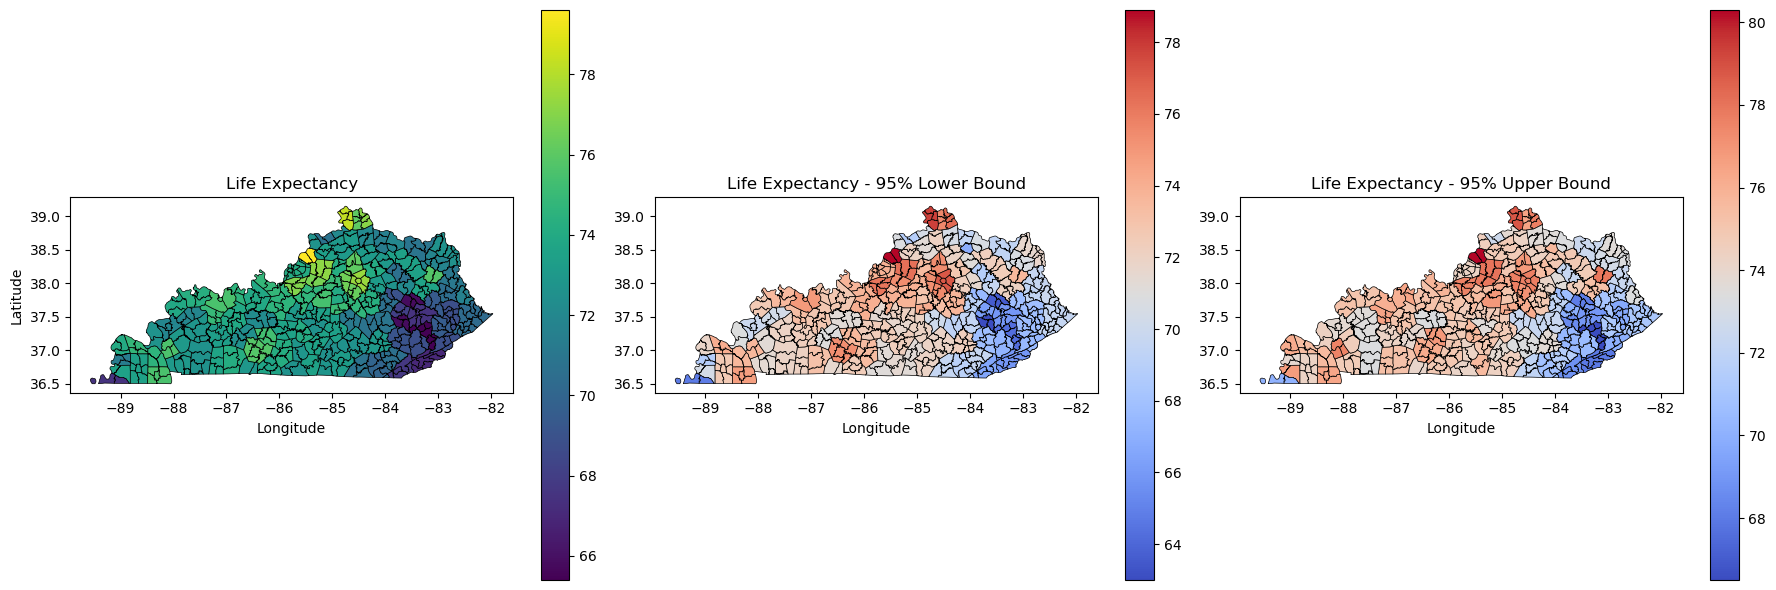

In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Life Expectancy
gdf_ky_counties.plot(column="life_exp", cmap="viridis", linewidth=0.5, edgecolor="black", legend=True, ax=axes[0])
axes[0].set_title("Life Expectancy")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Plot 95% Lower Bound
gdf_ky_counties.plot(column="95low", cmap="coolwarm", linewidth=0.5, edgecolor="black", legend=True, ax=axes[1])
axes[1].set_title("Life Expectancy - 95% Lower Bound")
axes[1].set_xlabel("Longitude")

# Plot 95% Upper Bound
gdf_ky_counties.plot(column="95high", cmap="coolwarm", linewidth=0.5, edgecolor="black", legend=True, ax=axes[2])
axes[2].set_title("Life Expectancy - 95% Upper Bound")
axes[2].set_xlabel("Longitude")

plt.tight_layout()
plt.show()

In [38]:
gdf_ky_counties

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,95low_x,95high_x,State_y,life_exp_y,95low_y,95high_y,State,life_exp,95low,95high
0,21,197,93352,01937275,2119793352,stanton,Stanton CCD,22,Z5,G4040,...,NaN,NaN,Kentucky,69.0,67.5,70.6,Kentucky,69.0,67.5,70.6
1,21,211,91616,01937047,2121191616,harrisonville,Harrisonville CCD,22,Z5,G4040,...,NaN,NaN,Kentucky,77.2,76.4,78.0,Kentucky,77.2,76.4,78.0
2,21,211,90696,01936932,2121190696,christianburg,Christianburg CCD,22,Z5,G4040,...,NaN,NaN,Kentucky,77.2,76.4,78.0,Kentucky,77.2,76.4,78.0
3,21,211,93232,01937260,2121193232,simpsonville,Simpsonville CCD,22,Z5,G4040,...,NaN,NaN,Kentucky,77.2,76.4,78.0,Kentucky,77.2,76.4,78.0
4,21,035,91936,01937091,2103591936,kirksey,Kirksey CCD,22,Z5,G4040,...,NaN,NaN,Kentucky,75.5,74.7,76.4,Kentucky,75.5,74.7,76.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,21,015,90440,01936900,2101590440,burlington,Burlington CCD,22,Z5,G4040,...,NaN,NaN,Kentucky,78.3,77.8,78.8,Kentucky,78.3,77.8,78.8
489,21,181,91664,01937053,2118191664,headquarters,Headquarters CCD,22,Z5,G4040,...,NaN,NaN,Kentucky,73.0,71.1,74.9,Kentucky,73.0,71.1,74.9
490,21,181,90592,01936919,2118190592,carlisle,Carlisle CCD,22,Z5,G4040,...,68.8,73.9,Kentucky,73.0,71.1,74.9,Kentucky,73.0,71.1,74.9
491,21,049,93269,01936934,2104993269,southeast clark,Southeast Clark CCD,22,Z5,G4040,...,NaN,NaN,Kentucky,73.2,72.2,74.2,Kentucky,73.2,72.2,74.2


In [39]:
import statsmodels.api as sm

# Select relevant columns for modeling
df_model = gdf_ky_counties[['oil_density', 'gas_density', 'life_exp']].dropna()

# Define independent variables (predictors) and dependent variable (response)
X = df_model[['oil_density', 'gas_density']]  # Predictor variables
y = df_model['life_exp']  # Response variable

# Add a constant for the intercept term
X = sm.add_constant(X)

In [40]:
# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               life_exp   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     61.42
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           1.57e-24
Time:                        09:26:52   Log-Likelihood:                -1122.0
No. Observations:                 493   AIC:                             2250.
Df Residuals:                     490   BIC:                             2263.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          73.1274      0.126    578.174      

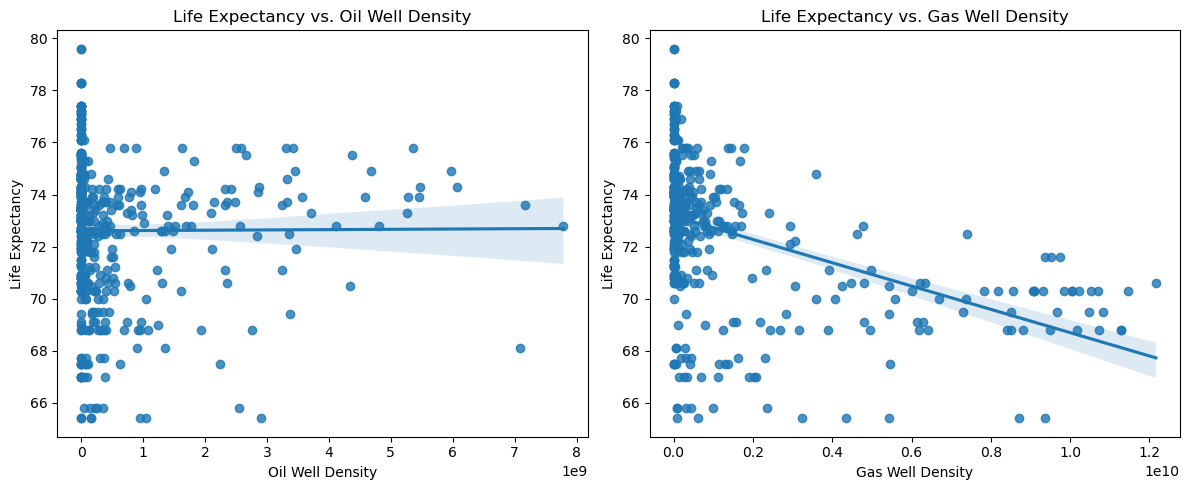

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with regression line for oil density vs life expectancy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.regplot(x=df_model["oil_density"], y=df_model["life_exp"])
plt.xlabel("Oil Well Density")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy vs. Oil Well Density")

# Scatter plot with regression line for gas density vs life expectancy
plt.subplot(1, 2, 2)
sns.regplot(x=df_model["gas_density"], y=df_model["life_exp"])
plt.xlabel("Gas Well Density")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy vs. Gas Well Density")

plt.tight_layout()
plt.show()

In [42]:
# Number of stochastic realizations
num_simulations = 100

# Store simulated maps
simulated_maps = []

# Define the standard deviation of noise (adjust based on uncertainty level)
noise_std = 1.5

# Generate multiple stochastic maps
for _ in range(num_simulations):
    # Predict life expectancy based on regression model
    gdf_ky_counties["simulated_life_exp"] = (
        model.predict(sm.add_constant(gdf_ky_counties[['oil_density', 'gas_density']])) 
        + np.random.normal(0, noise_std, size=len(gdf_ky_counties))
    )
    
    # Store the simulation
    simulated_maps.append(gdf_ky_counties["simulated_life_exp"].copy())

# Convert list to array
simulated_maps = np.array(simulated_maps)

# Compute mean simulated life expectancy per county
gdf_ky_counties["mean_simulated_life_exp"] = np.mean(simulated_maps, axis=0)

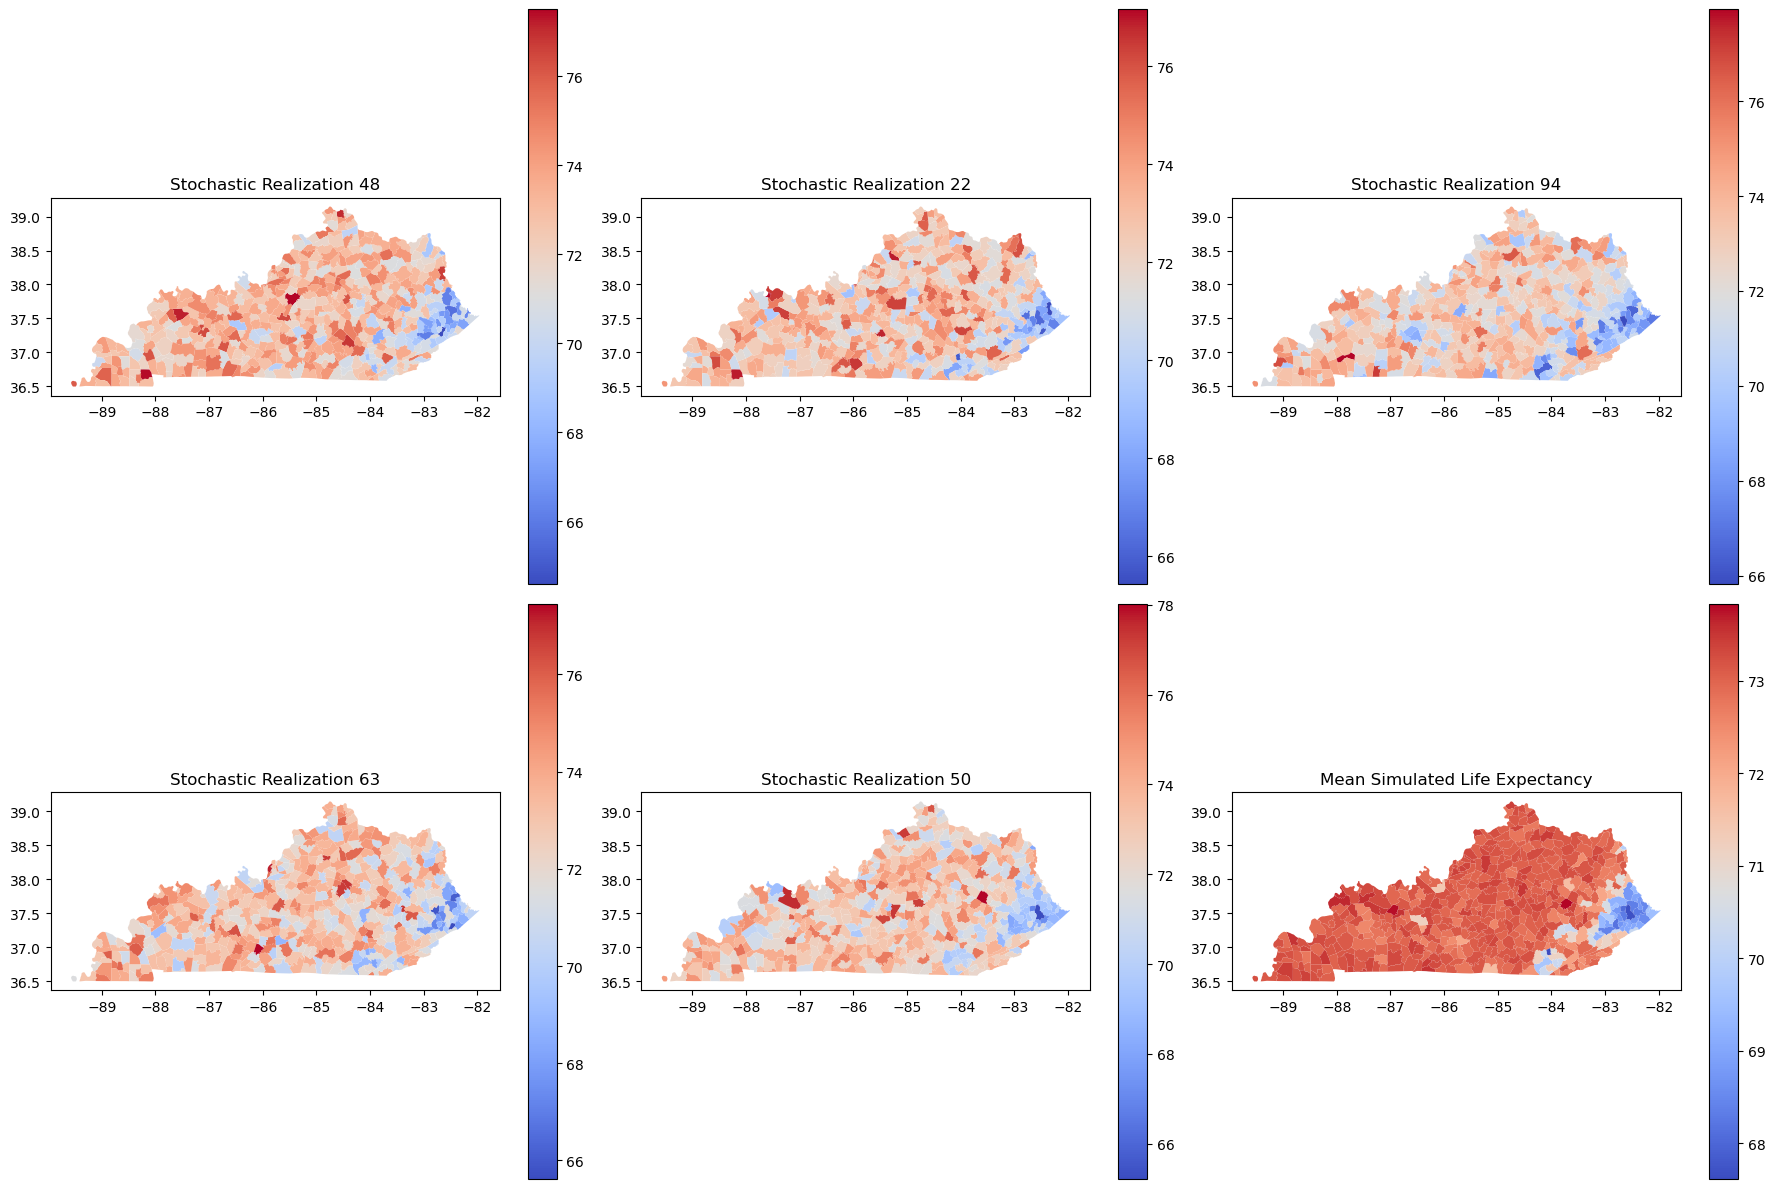

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Select random realizations to plot
random_indices = np.random.choice(num_simulations, size=5, replace=False)

for i, idx in enumerate(random_indices):
    ax = axes[i // 3, i % 3]
    gdf_ky_counties["simulated_life_exp"] = simulated_maps[idx]
    gdf_ky_counties.plot(column="simulated_life_exp", cmap="coolwarm", legend=True, ax=ax)
    ax.set_title(f"Stochastic Realization {idx + 1}")

# Plot the mean simulated life expectancy map
ax = axes[1, 2]
gdf_ky_counties.plot(column="mean_simulated_life_exp", cmap="coolwarm", legend=True, ax=ax)
ax.set_title("Mean Simulated Life Expectancy")

plt.tight_layout()
plt.show()